# Build a word count app with Spark

## This program will analyze top words from the works of edgar allen poe

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
# list of links for edgar allen poe books from gutenberg
links = ['https://www.gutenberg.org/files/2147/2147-0.txt',
        'http://www.gutenberg.org/cache/epub/2148/pg2148.txt',
        'http://www.gutenberg.org/cache/epub/2149/pg2149.txt',
        'http://www.gutenberg.org/cache/epub/2150/pg2150.txt',
        'http://www.gutenberg.org/cache/epub/2151/pg2151.txt']



In [4]:
# function for opening and return lines from text
import urllib

def open_and_read_lines(link):
    data = urllib.urlopen(link)
    return data.readlines()

# test it
text1 = open_and_read_lines(links[1])

In [5]:
text2 = open_and_read_lines(links[2])


In [6]:
print text2[3]
print text1[3]
text2[3] == text1[3]

almost no restrictions whatsoever.  You may copy it, give it away or

almost no restrictions whatsoever.  You may copy it, give it away or



True

## as you can see, the entry blocks are the same, so let's find out a way to chop off the entry block

In [7]:
import re

def find_beginning_of_text(lines):
    """ takes i a list of lines, finds the line that starts with contents and then increments until a blank block"""
    line_to_start_at = 0
    i = 0
    while not lines[i].lower().startswith("contents") and lines[i] != lines[len(lines) - 1]:
        i += 1
    # now increment until empty line is found
    while lines[i].strip().split():
        i += 1
    #now increment until first full line
    while not lines[i].strip().split():
        i+=1
    while not re.match(r'^([A-Z]+\s?)+$', lines[i].strip(), re.MULTILINE):
        print(re.match(r'([A-Z]+\s?)+$', lines[i].strip(), re.MULTILINE), lines[i].strip())
        i+=1
    
    return lines[i-1:]



In [8]:
r = re.match(r'^([A-Z]+\s?)+$', 'THE PURLOINED LETTER', re.MULTILINE)

In [9]:
# make the function that takes in an rdd of words and transforms the words into a word count rdd
def wordCounts(words_rdd):
    word_counts = words_rdd.map(lambda w: (w,1)).reduceByKey(lambda x,y: x+y)
    return word_counts


rdd_of_lines = (sc.parallelize(links)
                .map(open_and_read_lines) # open and read the lines
                .map(find_beginning_of_text) # find the beginning of the text in each file
                .flatMap(lambda lines: lines))

rdd_of_lines.cache()

PythonRDD[1] at RDD at PythonRDD.scala:43

## Next we have to strip, split, and remove punctuation from words


In [10]:
import re
def process_line(line):
    punc = r'--|[^a-zA-Z0-9\s-]'
    processed_line = map(lambda word: re.sub(punc,"",word), map(lambda w: w.lower(), line.strip().split()))
    return processed_line


In [11]:
wordsRDD = rdd_of_lines.flatMap(process_line)

wordsRDD.take(100)

['edgar',
 'allan',
 'poe',
 'an',
 'appreciation',
 'caught',
 'from',
 'some',
 'unhappy',
 'master',
 'whom',
 'unmerciful',
 'disaster',
 'followed',
 'fast',
 'and',
 'followed',
 'faster',
 'till',
 'his',
 'songs',
 'one',
 'burden',
 'bore',
 'till',
 'the',
 'dirges',
 'of',
 'his',
 'hope',
 'that',
 'melancholy',
 'burden',
 'bore',
 'of',
 'nevernever',
 'more',
 'this',
 'stanza',
 'from',
 'the',
 'raven',
 'was',
 'recommended',
 'by',
 'james',
 'russell',
 'lowell',
 'as',
 'an',
 'inscription',
 'upon',
 'the',
 'baltimore',
 'monument',
 'which',
 'marks',
 'the',
 'resting',
 'place',
 'of',
 'edgar',
 'allan',
 'poe',
 'the',
 'most',
 'interesting',
 'and',
 'original',
 'figure',
 'in',
 'american',
 'letters',
 'and',
 'to',
 'signify',
 'that',
 'peculiar',
 'musical',
 'quality',
 'of',
 'poes',
 'genius',
 'which',
 'inthralls',
 'every',
 'reader',
 'mr',
 'lowell',
 'suggested',
 'this',
 'additional',
 'verse',
 'from',
 'the',
 'haunted',
 'palace',
 'and

In [12]:
wordsRDD.count()

447819

In [13]:
wordCountsRDD = wordCounts(wordsRDD)

In [14]:
wordCountsRDD.takeOrdered(20, lambda (w,n): -1*n)

[('the', 32781),
 ('of', 19517),
 ('and', 12812),
 ('to', 10716),
 ('a', 10129),
 ('in', 9246),
 ('i', 7116),
 ('that', 4980),
 ('was', 4874),
 ('it', 4790),
 ('with', 4087),
 ('as', 3514),
 ('my', 3428),
 ('is', 3296),
 ('at', 3281),
 ('which', 3189),
 ('his', 2984),
 ('had', 2923),
 ('for', 2910),
 ('he', 2866)]

## Whoops, we forgot to remove the stopwords

In [15]:
## get stopwords from github

stopwords = 'https://raw.githubusercontent.com/fozziethebeat/S-Space/master/data/english-stop-words-large.txt'

#                                       process_line returns a list, we just wnat the first element
stopwords = map(lambda l: process_line(l)[0] ,
                map(lambda l: l.strip(), open_and_read_lines(stopwords))
               )

In [16]:
stopwords[:10]

['a',
 'as',
 'able',
 'about',
 'above',
 'according',
 'accordingly',
 'across',
 'actually',
 'after']

In [17]:
wordCountsRDD_filtered = wordCountsRDD.filter(lambda (w,n): w not in stopwords).cache()

In [18]:
wordCountsRDD_filtered.takeOrdered(100, lambda (w,n): -1*n)

[('found', 581),
 ('made', 568),
 ('time', 563),
 ('great', 517),
 ('long', 461),
 ('man', 448),
 ('project', 433),
 ('length', 378),
 ('mr', 370),
 ('eyes', 339),
 ('day', 319),
 ('thought', 306),
 ('head', 305),
 ('work', 305),
 ('night', 291),
 ('good', 291),
 ('full', 285),
 ('make', 284),
 ('left', 281),
 ('gutenberg-tm', 280),
 ('water', 277),
 ('feet', 271),
 ('means', 270),
 ('manner', 266),
 ('hand', 257),
 ('mind', 255),
 ('light', 251),
 ('thing', 250),
 ('back', 243),
 ('body', 242),
 ('words', 238),
 ('matter', 234),
 ('large', 234),
 ('part', 230),
 ('death', 222),
 ('point', 222),
 ('nature', 221),
 ('immediately', 220),
 ('idea', 218),
 ('fact', 217),
 ('heart', 216),
 ('doubt', 212),
 ('life', 211),
 ('de', 211),
 ('person', 209),
 ('air', 207),
 ('general', 207),
 ('sea', 207),
 ('lay', 205),
 ('moment', 203),
 ('world', 201),
 ('days', 200),
 ('door', 197),
 ('works', 197),
 ('years', 194),
 ('period', 194),
 ('fell', 194),
 ('appeared', 191),
 ('place', 191),
 ('alt

## still have lots of guttenberg words that are of no value

In [19]:
stopwords.extend(['gutenbergtm', 'gutenberg-tm', 'project',])

## REMEMBER TO BROADCAST BIG TABLES TO WORKERS SO THAT YOU DO NOT KEEP ON RESENDING IT

In [20]:
stopwords_broadcast = sc.broadcast(stopwords)

In [21]:
stopwords_broadcast.value

['a',
 'as',
 'able',
 'about',
 'above',
 'according',
 'accordingly',
 'across',
 'actually',
 'after',
 'afterwards',
 'again',
 'against',
 'aint',
 'all',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'an',
 'and',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'apart',
 'appear',
 'appreciate',
 'appropriate',
 'are',
 'arent',
 'around',
 'as',
 'aside',
 'ask',
 'asking',
 'associated',
 'at',
 'available',
 'away',
 'awfully',
 'b',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'believe',
 'below',
 'beside',
 'besides',
 'best',
 'better',
 'between',
 'beyond',
 'both',
 'brief',
 'but',
 'by',
 'c',
 'cmon',
 'cs',
 'came',
 'can',
 'cant',
 'cannot',
 'cant',
 'cause',
 'causes',
 'certain',
 'certainly',
 'changes',
 'clearly',
 'co',
 'com',
 'come',
 'comes',

In [22]:
wordCountsRDD_filtered = wordCountsRDD.filter(lambda (w,n): w not in stopwords_broadcast.value).cache()
wordCountsRDD_filtered.takeOrdered(100, lambda (w,n): -1*n)

[('found', 581),
 ('made', 568),
 ('time', 563),
 ('great', 517),
 ('long', 461),
 ('man', 448),
 ('length', 378),
 ('mr', 370),
 ('eyes', 339),
 ('day', 319),
 ('thought', 306),
 ('head', 305),
 ('work', 305),
 ('night', 291),
 ('good', 291),
 ('full', 285),
 ('make', 284),
 ('left', 281),
 ('water', 277),
 ('feet', 271),
 ('means', 270),
 ('manner', 266),
 ('hand', 257),
 ('mind', 255),
 ('light', 251),
 ('thing', 250),
 ('back', 243),
 ('body', 242),
 ('words', 238),
 ('matter', 234),
 ('large', 234),
 ('part', 230),
 ('death', 222),
 ('point', 222),
 ('nature', 221),
 ('immediately', 220),
 ('idea', 218),
 ('fact', 217),
 ('heart', 216),
 ('doubt', 212),
 ('life', 211),
 ('de', 211),
 ('person', 209),
 ('air', 207),
 ('general', 207),
 ('sea', 207),
 ('lay', 205),
 ('moment', 203),
 ('world', 201),
 ('days', 200),
 ('door', 197),
 ('works', 197),
 ('years', 194),
 ('period', 194),
 ('fell', 194),
 ('appeared', 191),
 ('place', 191),
 ('altogether', 190),
 ('end', 189),
 ('voice', 1

In [23]:
# now let's get the word frequencies
numTotalWords = wordCountsRDD_filtered.map(lambda (w,n): n).sum()

In [24]:
wordFrequencies = wordCountsRDD_filtered.map(lambda (w,n): (w,n/float(numTotalWords))).cache()

In [25]:
wordFrequencies.filter(lambda (k,v): v > .00001).takeOrdered(100, lambda (k,v): v)

[('porphyrogene', 1.1156854213385994e-05),
 ('hordes', 1.1156854213385994e-05),
 ('precocity', 1.1156854213385994e-05),
 ('consenting', 1.1156854213385994e-05),
 ('inanimate', 1.1156854213385994e-05),
 ('perforations', 1.1156854213385994e-05),
 ('china', 1.1156854213385994e-05),
 ('controversy', 1.1156854213385994e-05),
 ('cobblers', 1.1156854213385994e-05),
 ('projection', 1.1156854213385994e-05),
 ('lengthen', 1.1156854213385994e-05),
 ('nowhow', 1.1156854213385994e-05),
 ('grahams', 1.1156854213385994e-05),
 ('nebul', 1.1156854213385994e-05),
 ('printing-offices', 1.1156854213385994e-05),
 ('circumstanced', 1.1156854213385994e-05),
 ('morally', 1.1156854213385994e-05),
 ('disbelieving', 1.1156854213385994e-05),
 ('bristly', 1.1156854213385994e-05),
 ('snugly', 1.1156854213385994e-05),
 ('concurrence', 1.1156854213385994e-05),
 ('parasites', 1.1156854213385994e-05),
 ('indiscretion', 1.1156854213385994e-05),
 ('toute', 1.1156854213385994e-05),
 ('stamping', 1.1156854213385994e-05),
 

# Done, maybe I can make a histogram of the length of each words

In [26]:
avgWordLength = wordCountsRDD_filtered.map(lambda (w,n): len(w)).mean()


In [27]:
avgWordLength

8.145579972974819

In [28]:
avgLineLength = rdd_of_lines.map(lambda l: len(l.strip().split())).mean()

In [29]:
avgLineLength

9.53090282211721

# Graphs to make: word cloud, histogram of word lengths

In [30]:
all_words = wordCountsRDD_filtered.map(lambda (k,v): len(k)).collect()

(array([  0.00000000e+00,   1.10000000e+01,   1.78000000e+02,
          5.61000000e+02,   1.68200000e+03,   2.63000000e+03,
          3.53700000e+03,   4.06200000e+03,   4.01700000e+03,
          3.47000000e+03,   2.63400000e+03,   1.91900000e+03,
          1.31200000e+03,   8.55000000e+02,   4.65000000e+02,
          3.07000000e+02,   1.93000000e+02,   1.00000000e+02,
          6.20000000e+01,   3.60000000e+01,   2.40000000e+01,
          2.40000000e+01,   7.00000000e+00,   1.30000000e+01,
          5.00000000e+00,   1.00000000e+00,   8.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   2.00000000e+00]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.]),
 <a list of 30 Patch objects>)

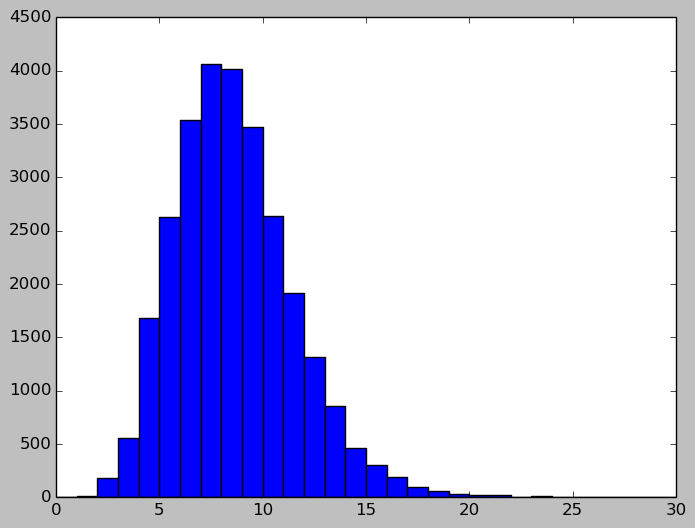

In [31]:
plt.hist(all_words, bins=30, range=(0,30))